Import dependencies

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from keras.utils import plot_model
import math
from keras.optimizers import RMSprop
import pickle


2023-02-01 17:34:11.274039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 17:34:11.375582: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 17:34:11.992011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-01 17:34:11.992095

Load the model and prepare the data

In [3]:
model = tf.keras.models.load_model('init_model')

2023-02-01 17:34:18.025763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13582 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-02-01 17:34:18.028038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1057 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [4]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad



In [5]:
test_dataset = pd.read_csv("fashion-mnist_test.csv")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

def data_preprocessing(raw):
    label = tf.keras.utils.to_categorical(raw.label, 10)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, 28, 28, 1)
    image = x_shaped_array / 255
    return image, label

X, y = data_preprocessing(test_dataset)
X_img = X.reshape(X.shape[0], 28, 28, 1)

In [6]:
y_pred = model.predict(X)

2023-02-01 17:34:45.808029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400


313/313 [==============================] - 3s 5ms/step


In [7]:
label = tf.one_hot(0, y_pred.shape[-1])
label = tf.reshape(label, (1, y_pred.shape[-1]))

<class 'numpy.ndarray'>


In [9]:
def display_images(image):
  plt.figure()
  plt.imshow(image*0.5+0.5, cmap = 'gray')
  plt.show()

Convert images to tensors

In [8]:
X_img_reshape = []
for im in X_img:
    im_res = im.reshape(1, 28, 28, 1)
    im_ten = tf.convert_to_tensor(im_res)
    X_img_reshape.append(im_ten)

10000
(1, 28, 28, 1)


For multiple epsilon values

In [ ]:
X_im_perturbate = X_img_reshape.copy()
eps = [0.001, 0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1]
#eps = [0.0001, 0.001]

print(X_im_perturbate[1].shape)
perturbated_list = []

for e in range(len(eps)):
    for n in range(10):
        for x in range(len(X_im_perturbate)):
            im = X_im_perturbate[x]
            perturbations = create_adversarial_pattern(im, label)
            adv_x = im + eps[e]*perturbations
            #clip function
            adv_x = tf.clip_by_value(im + eps[e], tf.math.maximum(0, tf.math.maximum(im-eps[e], adv_x)), 1)
            # clip from 0 to 1
            #adv_x = tf.clip_by_value(adv_x, 0, 1)
            X_im_perturbate[x] = adv_x
    display_images(X_im_perturbate[0])
    perturbated_list.append(X_im_perturbate)
    print(eps[e])
    X_im_perturbate = X_img_reshape.copy()
    
with open("image_iterate_one_eps_clipModified", "wb") as file:
        pickle.dump(perturbated_list, file)


For various iteration numbers

In [ ]:
X_im_perturbate = X_img_reshape.copy()
eps = 0.05

perturbated_list = []
print(eps)

for n in range(50):
    for x in range(len(X_im_perturbate)):
        im = X_im_perturbate[x]
        perturbations = create_adversarial_pattern(im, label)
        adv_x = im + eps*perturbations
        adv_x = tf.clip_by_value(im + eps, tf.math.maximum(0, tf.math.maximum(im-eps, adv_x)), 1)
        X_im_perturbate[x] = adv_x
    if n == 0:
        perturbated_list.append(X_im_perturbate.copy())
        display_images(X_im_perturbate[0][0])
        print(n)
    if n == 9:
        perturbated_list.append(X_im_perturbate.copy())
        display_images(X_im_perturbate[0][0])
        display_images(perturbated_list[0][0][0])
        print(n)       
    if n == 24:
        perturbated_list.append(X_im_perturbate.copy())
        display_images(X_im_perturbate[0][0])
        print(n)
    if n==49:
        perturbated_list.append(X_im_perturbate.copy())
        display_images(X_im_perturbate[0][0])
        print(n)
    X_im_perturbate = X_im_perturbate.copy()
    print(n)

    
with open("image_iterate_one_eps_clipModified", "wb") as file:
        pickle.dump(perturbated_list, file)

Open necessary files

In [30]:
file = open('image_iterate_list_clipInitial', 'rb')
perturbated_list = pickle.load(file)
file.close()

In [28]:
#for multiple iterations
loss = []
acc = []
iterations = [1, 10, 25, 50]
for i in range(len(iterations)): 
    img = np.concatenate(perturbated_list[i], axis=0)
    score = model.evaluate(img, y, steps=math.ceil(10000/32))
    loss.append(score[0])
    acc.append(score[1])


313/313 [==============================] - 2s 6ms/step - loss: 178.1423 - accuracy: 0.3748


In [31]:
#for different clipping methods
loss_initial = []
acc_initial = []
loss_modified = []
acc_modified = []
eps = [0.001, 0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
# eps = [0.0001, 0.001]
for e in range(len(eps)): 
    img_initial = np.concatenate(perturbated_list[e], axis=0)
    img_modified = np.concatenate(perturbated_list_modified[e], axis = 0)
    score_initial = model.evaluate(img_initial, y, steps=math.ceil(10000/32))
    score_modified = model.evaluate(img_modified, y, steps=math.ceil(10000/32))
    loss_initial.append(score_initial[0])
    acc_initial.append(score_initial[1])
    loss_modified.append(score_modified[0])
    acc_modified.append(score_modified[1])
    
    

313/313 [==============================] - 2s 6ms/step - loss: 325.9885 - accuracy: 0.1152


In [47]:
model_adv = tf.keras.models.load_model('adversarial_model')

In [48]:
score = model_adv.evaluate(X, y, steps=math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.1943 - accuracy: 0.9402
Test loss: 0.19428963959217072
Test accuracy: 0.9401999711990356


In [ ]:
loss_initial_adv = []
acc_initial_adv = []
loss_modified_adv = []
acc_modified_adv = []
eps = [0.001, 0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
# eps = [0.0001, 0.001]
for e in range(len(eps)): 
    img_initial = np.concatenate(perturbated_list[e], axis=0)
    img_modified = np.concatenate(perturbated_list_modified[e], axis=0)
    score_initial = model_adv.evaluate(img_initial, y, steps=math.ceil(10000/32))
    score_modified = model_adv.evaluate(img_modified, y, steps=math.ceil(10000/32))
    loss_initial_adv.append(score_initial[0])
    acc_initial_adv.append(score_initial[1])
    loss_modified_adv.append(score_modified[0])
    acc_modified_adv.append(score_modified[1])

313/313 [==============================] - 2s 6ms/step - loss: 46.8859 - accuracy: 0.1073


In [50]:
eps = [0.01,0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]


Visualizing the results

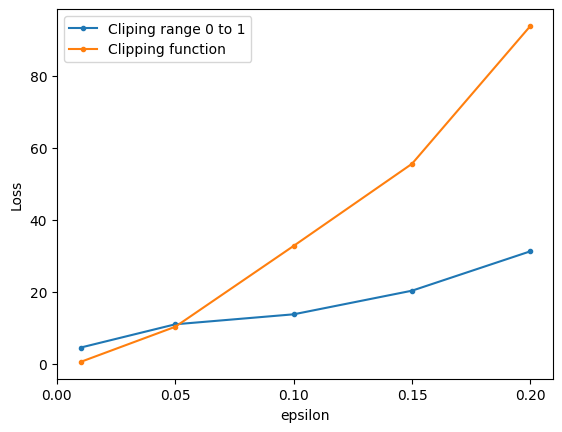

In [36]:
plt.plot(eps[1:6], loss_initial[1:6], marker=".", label = "Cliping range 0 to 1")
plt.plot(eps[1:6], loss_modified[1:6], marker=".", label = "Clipping function")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 0.25, step=0.05))
plt.ylabel("Loss")
plt.xlabel("epsilon")
plt.show()

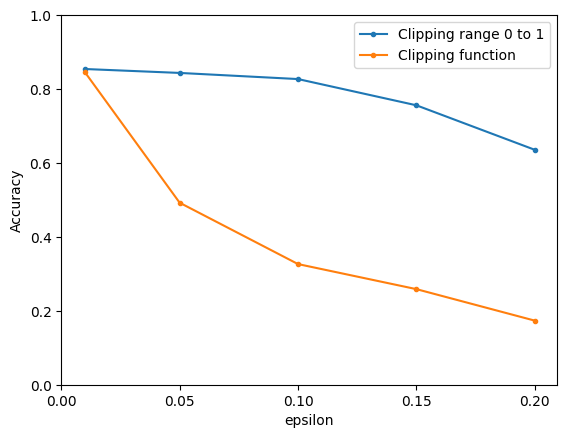

In [37]:
plt.plot(eps[1:6], acc_initial[1:6], marker=".", label = "Clipping range 0 to 1")
plt.plot(eps[1:6], acc_modified[1:6], marker=".", label = "Clipping function")
plt.legend(loc="upper right")
plt.xticks(np.arange(0, 0.25, step=0.05))
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("epsilon")
plt.show()